  0%|          | 0/3 [00:00<?, ?it/s]

Risk: 0.002


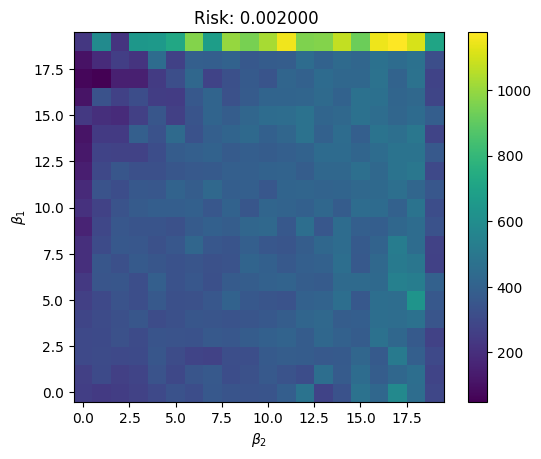

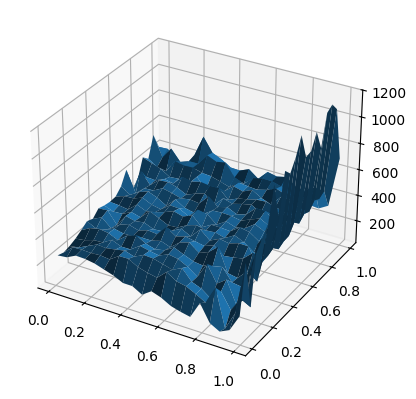

 33%|███▎      | 1/3 [00:35<01:10, 35.48s/it]

Risk: 1.000


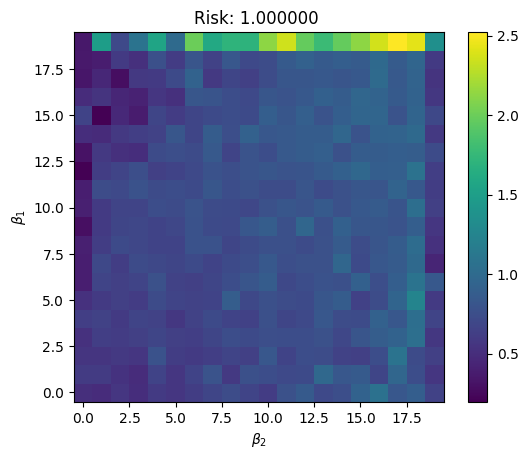

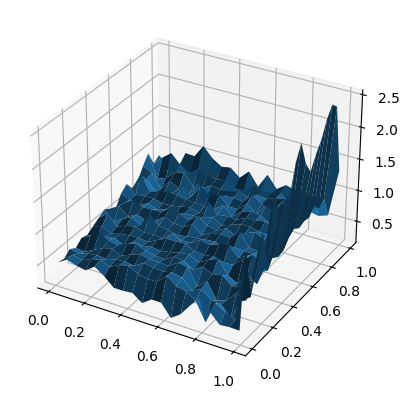

 67%|██████▋   | 2/3 [01:11<00:35, 35.61s/it]

Risk: 2.000


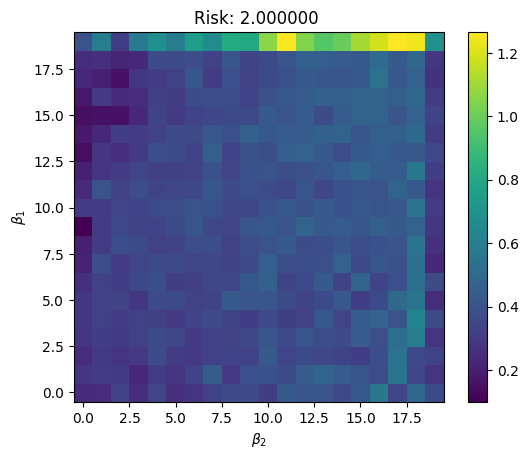

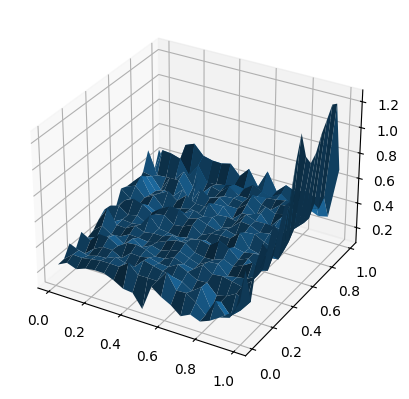

100%|██████████| 3/3 [01:46<00:00, 35.45s/it]


In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from risks_and_discounts import f_linreg, phi_from_B, cov_from_B
from tqdm import tqdm
from functools import partial
from jax import jit, vmap
import jax.numpy as jnp
import jax


rhos = [0.999, 0.5, 0.0]

for rho in tqdm(rhos):
    B = jnp.array([[1, rho], [rho, 1]])
    mini = 0.01
    maxi = 0.99
    num = 20
    betas = jnp.linspace(mini, maxi, num=num)
    num_samples = 1000
    key = jax.random.PRNGKey(0)

    risk = B[0,0] + B[1,1] - 2 * B[0,1]
    print(f"Risk: {risk:.3f}") # This is the risk of SGD in isotropic linear regression

    # Make grid of (beta1, beta2)
    beta1_grid, beta2_grid = jnp.meshgrid(betas, betas, indexing='ij')
    beta1_flat = beta1_grid.flatten()
    beta2_flat = beta2_grid.flatten()

    # Split keys
    keys = jax.random.split(key, beta1_flat.shape[0])

    # Partially apply fixed arguments
    phi_partial = partial(phi_from_B, B, f_linreg, num_samples=num_samples)
    cov_partial = partial(cov_from_B, B, f_linreg, num_samples=num_samples)

    # JIT and VMAP the function
    @jit
    def batch_phi(b1, b2, k):
        return phi_partial(b1, b2, k)
    @jit
    def batch_cov(b1, b2, k):
        return cov_partial(b1, b2, k)

    phi_vals = vmap(batch_phi)(beta1_flat, beta2_flat, keys)[:,0] # in linear regression, phi[0] = - phi[1] so combine into one function and take only first element
    cov_vals = vmap(batch_cov)(beta1_flat, beta2_flat, keys)[:,0,0]

    # save results
    phi_vals = jnp.array(phi_vals)
    cov_vals = jnp.array(cov_vals)
    jnp.savez(f'phi_cov_rho_{rho}_resolution1:{num}.npz', phi=phi_vals, cov=cov_vals)

    obj = phi_vals**2 / cov_vals # similar to clip this ratio compares adam to sgd in isotropic linear regression (bigger is better)
    obj_grid = obj.reshape(len(betas), len(betas))

    # Plotting
    fig, ax = plt.subplots()
    c = ax.imshow(obj_grid, extent= [mini,maxi,mini,maxi], origin='lower', cmap='viridis')    
    ax.set_xlabel(r'$\beta_2$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_title(f'Risk: {risk:3f} ')
    fig.colorbar(c, ax=ax)
    plt.show()
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(beta1_grid, beta2_grid, obj_grid)
    plt.show()

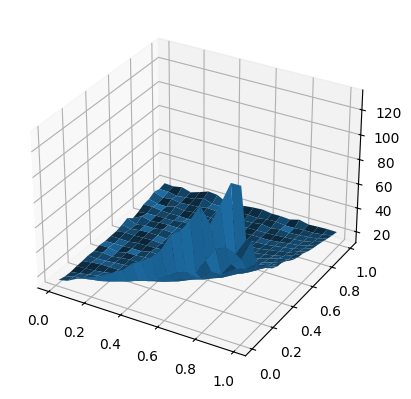

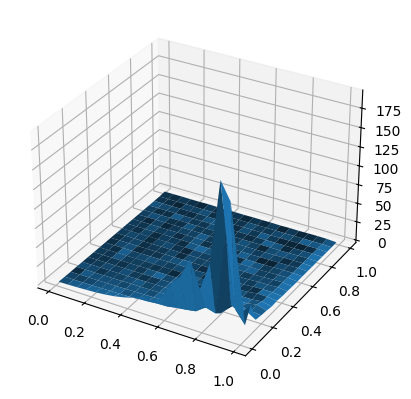

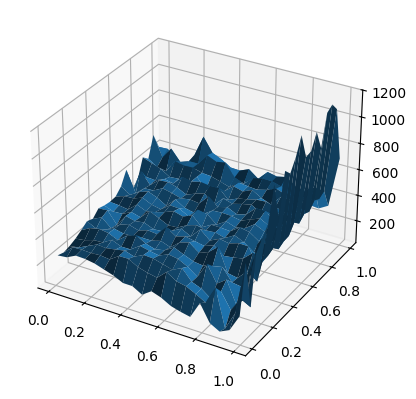

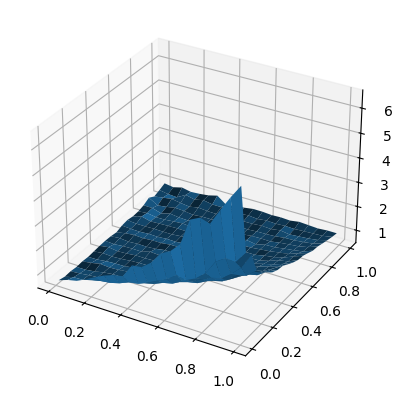

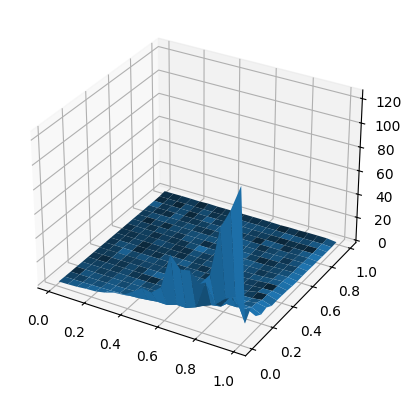

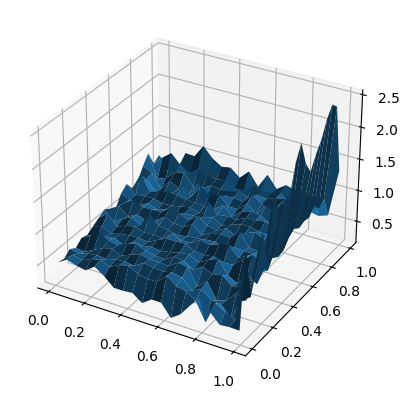

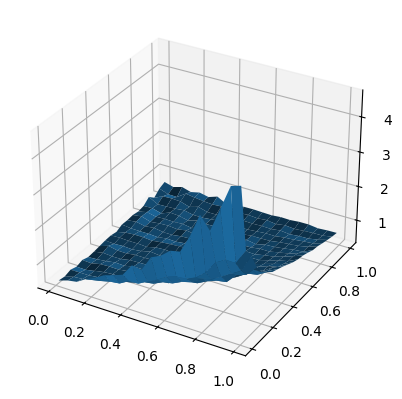

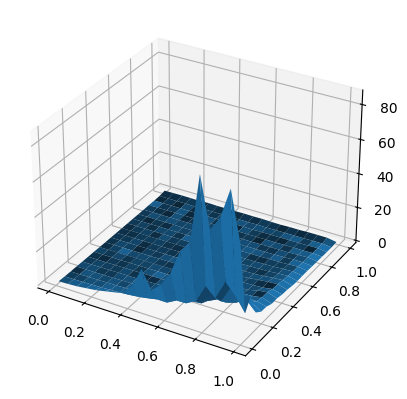

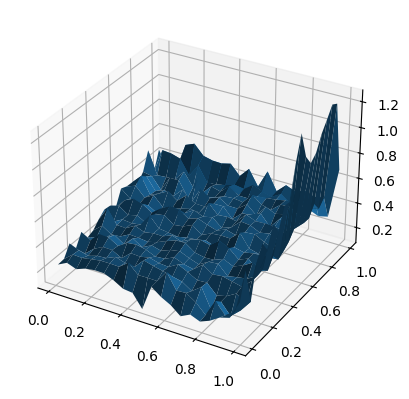

In [26]:
for rho in rhos:
    data = jnp.load(f'phi_cov_rho_{rho}_resolution1:{num}.npz')
    phi_vals = data['phi']
    cov_vals = data['cov']

    phi_grid = phi_vals.reshape(len(betas), len(betas))

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(beta1_grid, beta2_grid, phi_grid)
    plt.show()

    # plot surface plot of just phi
    cov_grid = cov_vals.reshape(len(betas), len(betas))

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(beta1_grid, beta2_grid, cov_grid)
    plt.show()
    
    obj_grid = (phi_vals**2 / cov_vals).reshape(len(betas), len(betas))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(beta1_grid, beta2_grid, obj_grid)
    plt.show()

## Let's plot phi for logistic regression now

  0%|          | 0/3 [00:00<?, ?it/s]

Risk: 0.002


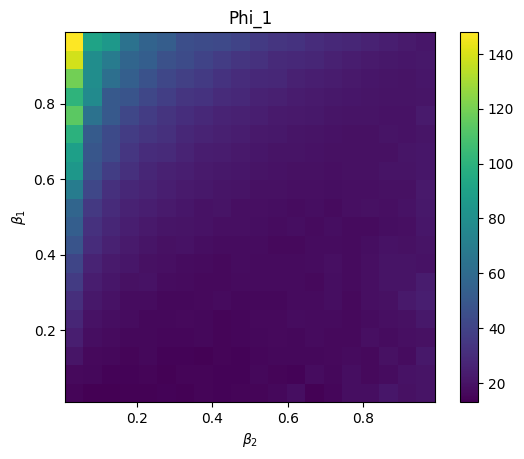

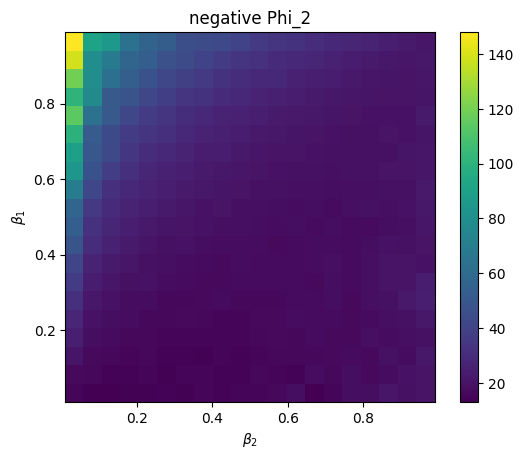

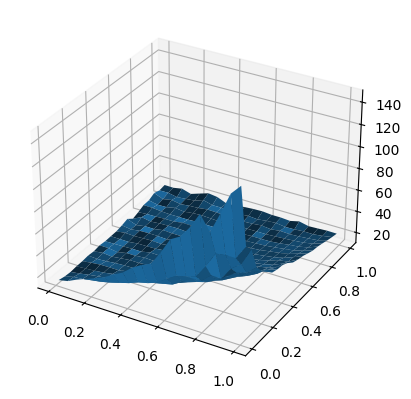

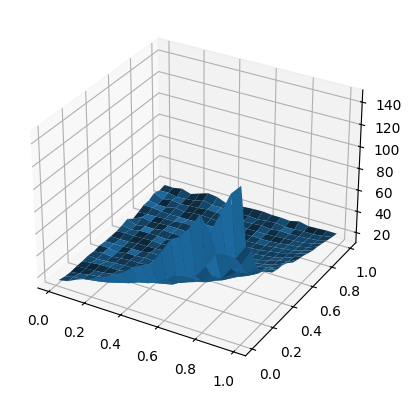

 33%|███▎      | 1/3 [00:15<00:30, 15.39s/it]

Risk: 1.000


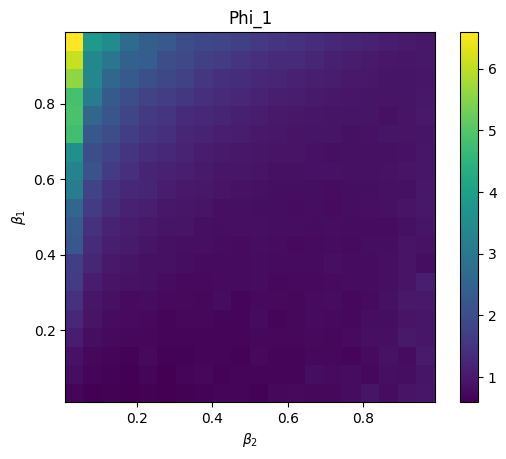

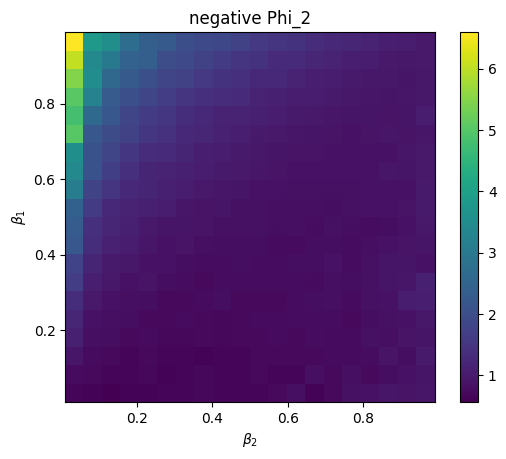

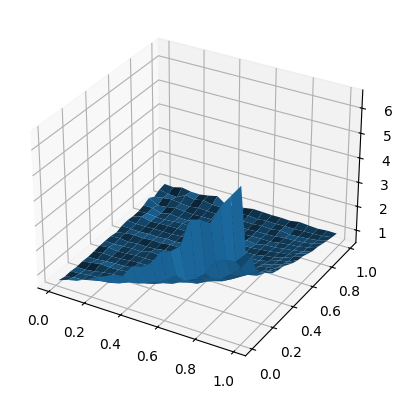

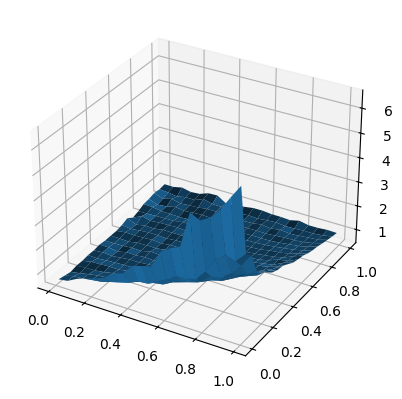

 67%|██████▋   | 2/3 [00:29<00:14, 14.91s/it]

Risk: 2.000


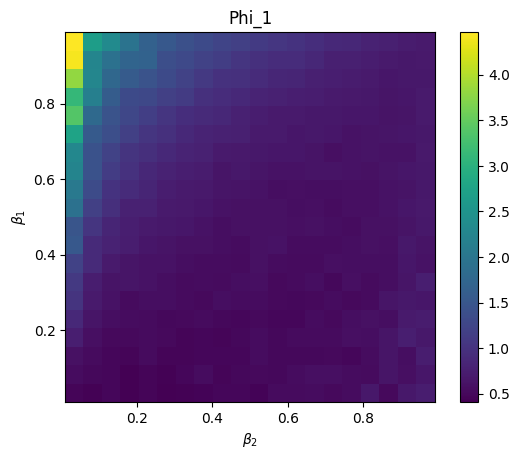

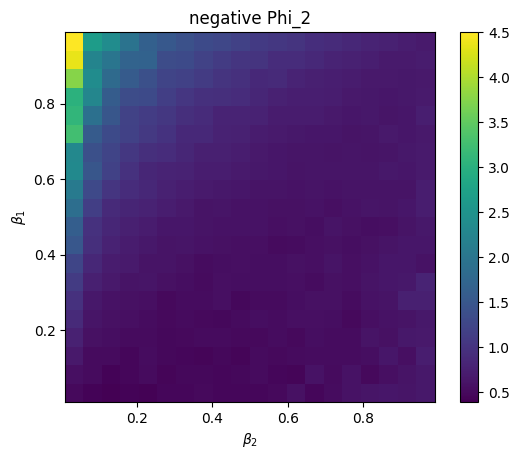

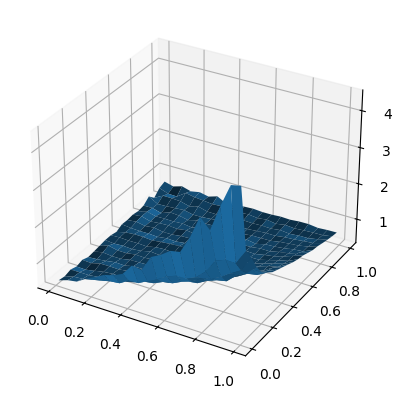

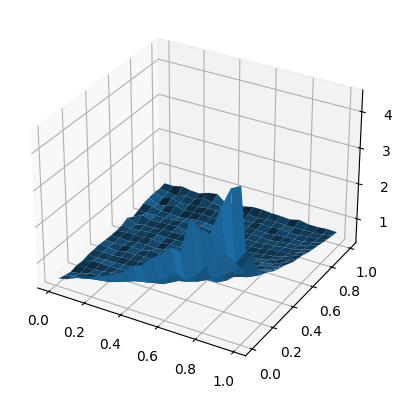

100%|██████████| 3/3 [00:45<00:00, 15.20s/it]


In [32]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from risks_and_discounts import f_logreg, phi_from_B
from tqdm import tqdm
from functools import partial
from jax import jit, vmap
import jax.numpy as jnp
import jax


rhos = [0.999, 0.5, 0.0]

for rho in tqdm(rhos):
    B = jnp.array([[1, rho], [rho, 1]])
    mini = 0.01
    maxi = 0.99
    num = 20
    betas = jnp.linspace(mini, maxi, num=num)
    num_samples = 1000
    key = jax.random.PRNGKey(0)

    risk = B[0,0] + B[1,1] - 2 * B[0,1]
    print(f"Risk: {risk:.3f}")

    # Make grid of (beta1, beta2)
    beta1_grid, beta2_grid = jnp.meshgrid(betas, betas, indexing='ij')
    beta1_flat = beta1_grid.flatten()
    beta2_flat = beta2_grid.flatten()

    # Split keys
    keys = jax.random.split(key, beta1_flat.shape[0])

    # Partially apply fixed arguments
    phi_partial = partial(phi_from_B, B, f_logreg, num_samples=num_samples)

    # JIT and VMAP the function
    @jit
    def batch_phi(b1, b2, k):
        return phi_partial(b1, b2, k)
    @jit
    def batch_cov(b1, b2, k):
        return cov_partial(b1, b2, k)

    phi_vals = vmap(batch_phi)(beta1_flat, beta2_flat, keys)
    phi1_vals = phi_vals[:,0]
    phi2_vals = phi_vals[:,1]
    

    # save results
    # phi_vals = jnp.array(phi_vals)
    # cov_vals = jnp.array(cov_vals)
    # jnp.savez(f'phi_cov_rho_{rho}_resolution1:{num}.npz', phi=phi_vals, cov=cov_vals)


    phi1_grid = phi1_vals.reshape(len(betas), len(betas))
    phi2_grid = phi2_vals.reshape(len(betas), len(betas))

    # Plotting
    fig, ax = plt.subplots()
    c = ax.imshow(phi1_grid, extent= [mini,maxi,mini,maxi], origin='lower', cmap='viridis')    
    ax.set_xlabel(r'$\beta_2$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_title(f'Phi_1')
    fig.colorbar(c, ax=ax)
    plt.show()
        
    fig, ax = plt.subplots()
    c = ax.imshow(-phi2_grid, extent= [mini,maxi,mini,maxi], origin='lower', cmap='viridis')
    ax.set_xlabel(r'$\beta_2$')
    ax.set_ylabel(r'$\beta_1$')    
    fig.colorbar(c, ax=ax)
    ax.set_title(f'negative Phi_2')
    plt.show()
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(beta1_grid, beta2_grid, phi1_grid)
    plt.show()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(beta1_grid, beta2_grid, -phi2_grid)
    plt.show()